In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


In [11]:
CHAR_MAPPING = {
    "x" : -1,
    "." : 0,
    "H" : 1,
    "h" : 2, 
    "s": 3
}
COLOR_MAPPING = ["black", "white", "blue", "green", "red"]
MAP_SIMPLE_NAME = "map.txt"

def load_map(mapname, char_mapping):
    with open(mapname, 'r') as map_file:
        lines = map_file.readlines()
        width = int(lines[0])
        height = int(lines[1])
        map_numbers = [[char_mapping[chr] for chr in row[:-1]] for row in lines[2:]]
    return np.array(map_numbers, dtype = np.int32)


  
    #plt.figure()
    #plt.imshow(map , cmap = matplotlib.colors.ListedColormap(COLOR_MAPPING))

    #plt.show()

simple_map = load_map(MAP_SIMPLE_NAME, CHAR_MAPPING)
hider_pos = np.asarray(np.where(simple_map == CHAR_MAPPING["h"])).reshape(2)
seeker_pos = np.asarray(np.where(simple_map == CHAR_MAPPING["s"])).reshape(2)
#start configuration
MAP_START = np.copy(simple_map)
MAP_START[hider_pos[0], hider_pos[1]] = CHAR_MAPPING["."]
MAP_START[seeker_pos[0], seeker_pos[1]] = CHAR_MAPPING["."]




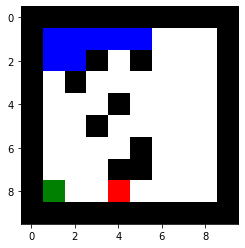

array([0., 0.])

In [12]:
f = plt.figure()
graph1 = f.add_subplot(211)
def plot_map(map):
    clear_output(wait=True)
    plt.figure()
    plt.imshow(map , cmap = matplotlib.colors.ListedColormap(COLOR_MAPPING))
    plt.show()

def get_percepts(map_env, pos, agent = "h"):
    VISION = 1
    return map_env [pos[0] - VISION : pos[0] + VISION, pos[1] - VISION : pos[1] + VISION]

ACTIONS = [[0,0], [-1,0], [1, 0], [0, -1], [0, 1]]

def is_free(map_env, pos, agent):
    if (agent == "h"):
        return map_env[pos[0], pos[1]] in [CHAR_MAPPING["."], CHAR_MAPPING["H"], CHAR_MAPPING["h"]]
    return map_env[pos[0], pos[1]] in [CHAR_MAPPING["."], CHAR_MAPPING["s"]]


def do_action(map_env, pos, action, agent):
    new_pos = pos + ACTIONS[action]
    #print(new_pos)
    if is_free(map_env, new_pos, agent) and not np.all(new_pos == pos):
        #print(True)
        map_env[new_pos[0], new_pos[1]] = CHAR_MAPPING[agent]
        map_env[pos[0], pos[1]] = MAP_START[pos[0], pos[1]]
        return map_env, new_pos
    else:
        #print(False)
        return map_env, pos




def simulate_step(map_env, pos_hide, pos_seek, policy_hide, policy_seek, **kwargs):

    action_hide = policy_hide(get_percepts(map_env, pos_hide, "h"),"s", **kwargs)
    map_env, new_pos_hide = do_action(map_env, pos_hide, action_hide, "h")
    action_seek = policy_seek(get_percepts(map_env, pos_seek, "s"), "s", **kwargs)
    map_env, new_pos_seek = do_action(map_env, pos_seek, action_seek, "s")
    return (map_env, new_pos_hide, new_pos_seek)

import time
from IPython.display import clear_output
def eval_map_state(_, _1, _2):
    #TODO 
    return 0

def is_end(map_env, pos_hide, pos_seek):
    return False

def simulate(map_orig, start_hide, start_seek, policy_hide, policy_seek, num_steps = 100, **kwargs):
    pos_hide, pos_seek = start_hide, start_seek
    map_env = np.copy(map_orig)
    scores = np.zeros(2)
    for step in range(num_steps):
        map_env, pos_hide, pos_seek = simulate_step(map_env, pos_hide, pos_seek, policy_hide, policy_seek, **kwargs)
        time.sleep(0.03)
        plot_map(map_env)
        scores += eval_map_state(map_env, pos_hide, pos_seek)
        if(is_end(map_env, pos_hide, pos_seek)):
            break
    return scores

def random_policy(percepts, agent, **kwargs):
    return np.random.randint(len(ACTIONS))
#print(simple_map)

simulate(simple_map, hider_pos, seeker_pos, random_policy, random_policy)


In [13]:

import neat

def NN_policy(percepts, agent, **kwargs):
    if agent == "h":
        network = kwargs.get("seek_net")
    else:
        network = kwargs.get("hide_net")
    output = network.activate(percepts.reshape(-1))
    return np.argmax(output)


In [14]:
#todo fic parttools last two arguments
import functools

def fitness_seek(genomes, config, start_hide, start_seek, default_map_state, hider_net):
    for genome_id, genome in genomes:        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = simulate(default_map_state, start_hide, 
            start_seek, NN_policy, NN_policy, 
            num_steps = 100, seek_net = net, hider_net = hider_net)[1]

def fitness_hide(genomes, config, start_hide, start_seek, default_map_state, seek_net):
    for genome_id, genome in genomes:        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = simulate(default_map_state, start_hide, 
            start_seek, NN_policy, NN_policy, 
            num_steps = 100, seek_net = seek_net, hider_net = net)[0]

def run_evolution(config_file, map_env, start_hide, start_seek,  main_it_count = 20):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    seek_pop = neat.Population(config)
    hide_pop = neat.Population(config)
    seek_pop.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    seek_pop.add_reporter(stats)
    seek_pop.add_reporter(neat.Checkpointer(5))
    #TODO how to init winner
    winner_seek = seek_pop[0]
    winner_hide = hide_pop[0]
    for _ in range(main_it_count):
             
        # Run for up to 300 generations.
        #TODO how to return whole population ?
        fit_seek_fixed = functools.partial(fitness_seek, default_map_state = map_env, hider_net = winner_hide)
        winner_seek = seek_pop.run(fit_seek_fixed, 10)
        fit_hide_fixed = functools.partial(fitness_hide, default_map_state = map_env, seek_net = winner_seek)
        winner_hide = seek_pop.run(fit_seek_fixed, 10)
    


    #TODO adjust below
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    #for xi, xo in zip(xor_inputs, xor_outputs):
    #    output = winner_net.activate(xi)
    #    print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
    visualize.draw_net(config, winner, True, node_names=node_names)
    visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=True)
    visualize.plot_stats(stats, ylog=False, view=True)
    visualize.plot_species(stats, view=True)

    p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    p.run(eval_genomes, 10)

SyntaxError: invalid syntax (Temp/ipykernel_26084/3552418312.py, line 18)